# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [119]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [120]:
import gym
import numpy as np

env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [121]:
# get env properties
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


In [122]:
# stochastic policy is probability for each state
def initialize_policy(n_states, n_actions):
    # policy = np.full((n_states, n_actions), 1/n_actions)
    policy = np.ones((n_states, n_actions))/n_actions
    
    return policy

policy = initialize_policy(n_states, n_actions)

In [123]:
# play one episode (turn) of t_max actions and return the results
def play_episode(env, policy, t_max=10**4):

    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        # choice an action 'a' from range(6) using probability for the state 's'
        a = np.random.choice(list(range(6)), p=policy[s])            

        new_s, r, done, info = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward

#### Having uniform action probability, let's play 200 episodes, collect the rewards and see the reward distribution

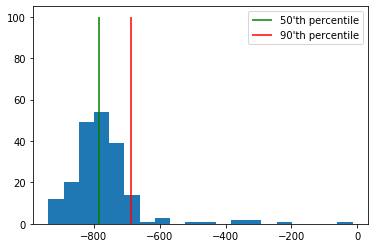

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

# play 200 episodes, t_max actions each, and take rewards only
rewards = [play_episode(env, policy, t_max=1000)[-1] for _ in range(200)]

# let's see the initial reward distribution
plt.hist(rewards, bins=20)
plt.vlines([np.percentile(rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(rewards, 90)], [0], [100], label="90'th percentile", color='red')
# plt.vlines([np.percentile(rewards, 100)], [0], [100], label="90'th percentile", color='red')
plt.legend();

In [125]:
# percentile usage
np.percentile(rewards, 10)

-866.9

### Crossentropy method steps

In [126]:
# Let's separate the most successful episodes using reward percentile
def select_elite_episodes(states_batch, actions_batch, rewards_batch, percentile):
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_indexes = []
    elite_states = []
    elite_actions= []

    for idx, reward in enumerate(rewards_batch):
        if reward >= reward_threshold:
            elite_states.extend(states_batch[idx])
            elite_actions.extend(actions_batch[idx])


    return elite_states, elite_actions

In [127]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    elite_states_a = np.array(elite_states)
    elite_actions_a = np.array(elite_actions)

    state_actions = []

    for s in range(n_states):
        state_actions = elite_actions_a[elite_states_a == s]
        if len(state_actions) > 0:
            case_prob = 1/len(state_actions)
            for a in state_actions:
                new_policy[s][a] += case_prob
        else: new_policy[s] = 1/n_actions

    return new_policy

In [128]:
def get_new_policy_2(elite_states, elite_actions):

    new_policy = np.zeros([n_states, n_actions])

    state_actions = []
 
    # transfer state actions to policy array
    for i, s in enumerate(elite_states):
        new_policy[s][elite_actions[i]] += 1

    # turn actions into probabilities
    # devide each non-zerro row by its sum
    # set default probability for unvisited states
    new_policy[new_policy.sum(axis=1) >= 1] /= new_policy[new_policy.sum(axis=1) >= 1].sum(axis=1)[:,None]
    new_policy[new_policy.sum(axis=1) == 0] = 1/n_actions


    return new_policy

# Training loop
Generate sessions, select N best and fit to those.

In [129]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range, bins=50)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

mean reward = -26.816, threshold=1.000


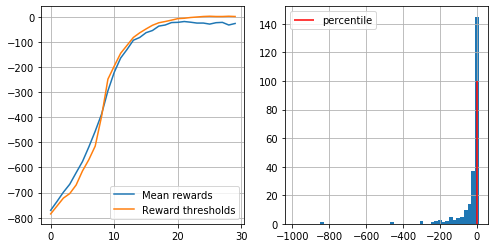

In [130]:
n_episodes = 250     # sample this many sessions
percentile = 50      # take this percent of session with highest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in range(50):
    %time episodes = [play_episode(env, policy) for _ in range(n_episodes)]

    states_batch, actions_batch, rewards_batch = zip(*episodes)

    elite_states, elite_actions = select_elite_episodes(states_batch, actions_batch, rewards_batch, percentile)
    

    new_policy = get_new_policy_2(elite_states, elite_actions)

    # initialy policy = 1/6, but moves to the new_policy side each loop according to the learning_rate
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile);

In [131]:
print(policy)

[[1.66666667e-01 1.66666667e-01 1.66666667e-01 1.66666667e-01
  1.66666667e-01 1.66666667e-01]
 [3.91996261e-07 2.10385544e-01 1.93889884e-01 5.78217761e-06
  5.95707535e-01 1.08624687e-05]
 [1.40566117e-06 3.53789920e-04 5.84259060e-02 1.12238602e-01
  8.28945647e-01 3.46491963e-05]
 ...
 [1.62323455e-01 1.61863714e-01 1.61458487e-01 1.91434305e-01
  1.61461698e-01 1.61458342e-01]
 [1.66536337e-01 1.67159943e-01 1.66670479e-01 1.66611278e-01
  1.66506384e-01 1.66515580e-01]
 [4.95812502e-06 1.62594487e-06 9.40910379e-03 9.90487792e-01
  7.61392654e-05 2.03813358e-05]]


In [135]:
s = env.reset()

done = False
while not done:
    env.render()
    actions = policy[s] 
    a = np.argmax(actions)    
    new_s, r, done, info = env.step(a)
    print(a, r)
    s = new_s



+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

1 -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
3 -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
3 -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
0 -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
0 -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
4 -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
1 -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
1 -1
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
2 -1
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
2 -1
+---------+
|R: | : :

### Reflecting on results

You may have noticed that the taxi problem quickly converges from less than -1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or change the way you evaluate strategy (theoretically correct way). For each starting state, you can sample an action randomly, and then evaluate this action by running _several_ games starting from it and averaging the total reward. Choosing elite sessions with this kind of sampling (where each session's reward is counted as the average of the rewards of all sessions with the same starting state and action) should improve the performance of your policy.